# A Comparative Study of Models Trained on Real and Synthetic Data

The synthetic data generator used in this study was developed by [Dr. Vincent Granvile](https://mltechniques.com/author/). This synthetic data generator represents an early version of his Generative AI technique, which is described in [his book](https://mltechniques.com/product/ebook-synthetic-data/).

The following code cell imports the necessary libraries, ingests the input data, and displays a subset of the ingested data.

To ensure reproducibility, a random seed is set for generating the synthetic data.

The simulated input data pertains to the watch completion rate of Disney Plus shows. Watch completion rate is a critical metric for online streaming companies as it reflects user satisfaction and consumption patterns. In this example, demographic and intention data are available and can be used as input features for the machine learning model.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf

df = pd.read_csv('disney_plus.csv')
df.dropna() ## delete rows with null values
print(df.head())

np.random.seed(333)

  interested_in wants_to_buy state_code  family_size  \
0         movie        shoes         NC            4   
1          food    cellphone         WA            4   
2          food        shoes         WA            2   
3          food        house         OR            5   
4         movie        shoes         WA            2   

                             recommended_to_watch  watch_completion_rate  
0                  Guardians of the Galaxy Vol. 3               0.526897  
1          Marvel Studios’ Thor: Love and Thunder               0.914478  
2                  Guardians of the Galaxy Vol. 3               0.552586  
3  Marvel Studios’ Black Panther: Wakanda Forever               0.667572  
4                                   Strange World               0.608243  


The input data is divided into two sets: **training** and **validation**. The training set comprises 80% of the input data, while the remaining data is allocated to the validation set.

A linear regression model is then constructed, with `watch_completion_rate` serving as the dependent variable. The independent variables used in the model include `interested_in`, `wants_to_buy`, `state_code`, `family_size`, and `recommended_to_watch`.

To evaluate the performance of the model, the R-squared value is calculated using the validation dataset. The R-squared value provides an indication of how well the model fits the observed data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

training, validation = train_test_split(df, test_size=0.2)

model = smf.ols(formula='watch_completion_rate ~ \
  interested_in + \
  wants_to_buy + \
  state_code + \
  family_size + \
  recommended_to_watch', data=training)
result = model.fit()
print(result.summary())

validation_prediction = result.predict(validation)
observed_response = validation['watch_completion_rate']

mse = mean_squared_error(observed_response, validation_prediction)
r2 = r2_score(observed_response, validation_prediction)

print('Validation MSE: ', mse)
print('Validation R-squared: ', r2)

                              OLS Regression Results                             
Dep. Variable:     watch_completion_rate   R-squared:                       0.683
Model:                               OLS   Adj. R-squared:                  0.682
Method:                    Least Squares   F-statistic:                     6878.
Date:                   Thu, 28 Sep 2023   Prob (F-statistic):               0.00
Time:                           17:05:31   Log-Likelihood:                 56891.
No. Observations:                  80000   AIC:                        -1.137e+05
Df Residuals:                      79974   BIC:                        -1.135e+05
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

The following code cell generates a chart that compares the real and predicted values in the validation dataset. The chart shows the R-squared value, which is found to be 0.68.

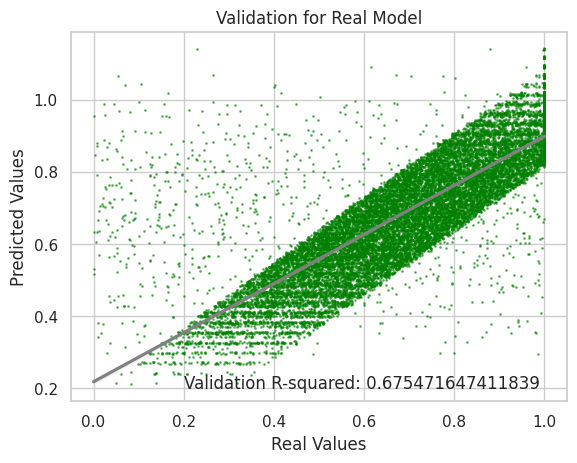

In [ ]:
import matplotlib.pyplot as plt

sns.regplot(x=observed_response, y=validation_prediction, scatter_kws={'alpha':0.5, \
            'color':'green', 's':1}, line_kws={'color': 'gray'})

plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Validation for Real Model')

r2_text = 'Validation R-squared: ' + str(r2)
plt.text(0.2, 0.2, r2_text)

plt.show()


Simulating the input data set posed a challenge. In this study, we aim to train a machine learning model that accurately captures the observed data. To achieve this, I introduced artificial patterns into the input data.
As evident from the scatter plot below, customers who express interest in movies and music exhibit higher watch completion rates.

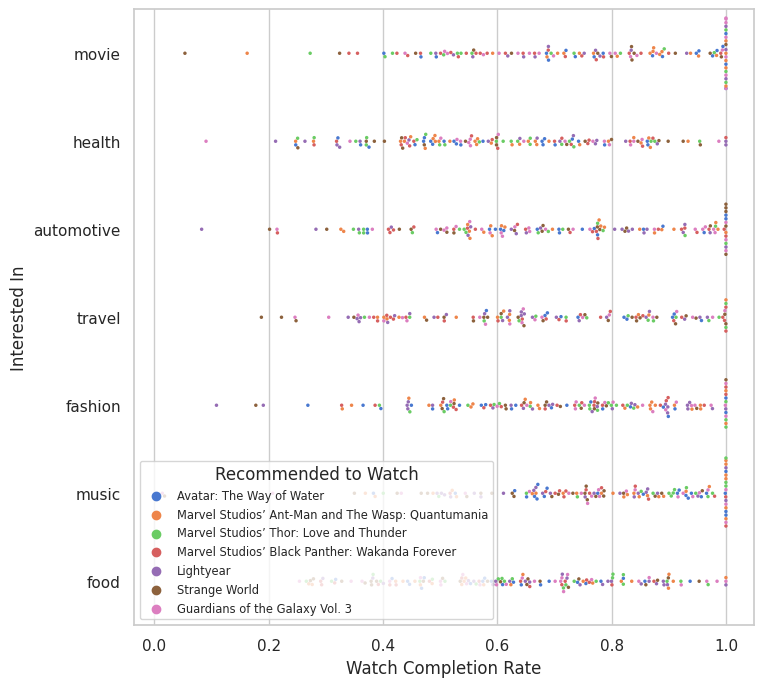

In [ ]:
sns.set_theme(style="whitegrid", palette="muted")

f, ax = plt.subplots(figsize=(8, 8))

df_1pct = df.sample(frac=0.01, random_state=42)

ax = sns.swarmplot(data=df_1pct, x="watch_completion_rate", y="interested_in", hue="recommended_to_watch", legend="brief", size=2.5)
ax.set(xlabel="Watch Completion Rate")
ax.set(ylabel="Interested In")

sns.move_legend(ax, "lower left", title="Recommended to Watch", fontsize="x-small")

Another artificial pattern that I introduced into the input data is a strong correlation between family size and watch completion rate. To visualize this relationship, the following chart displays both the population density and the correlation between family size and watch completion rate.

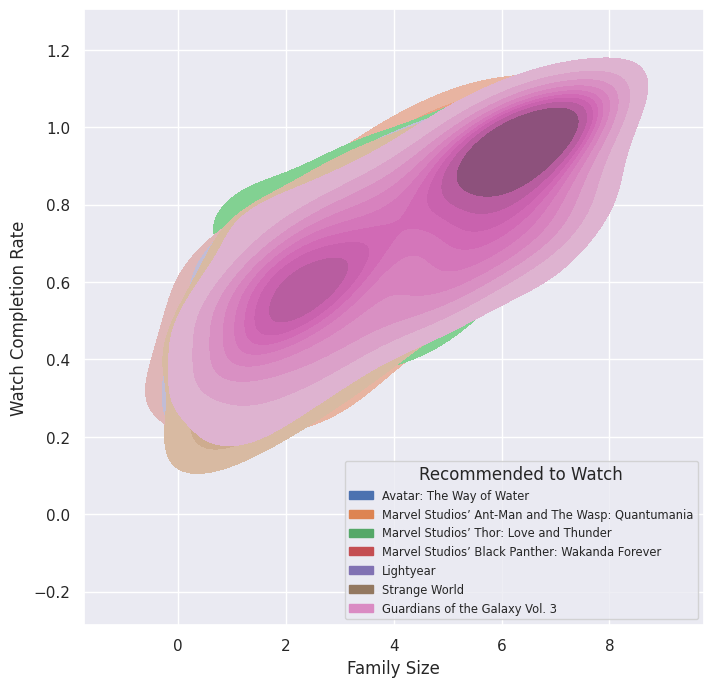

In [ ]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(8, 8))
##ax.set_aspect("equal")

df_1pct = df.sample(frac=0.01, random_state=42)

sns.kdeplot(
    ##data=df.query("interested_in != 'movie'"),
    data=df_1pct,
    x="family_size",
    y="watch_completion_rate",
    hue="recommended_to_watch",
    thresh=.1,
    fill=True
)

ax.set(xlabel="Family Size")
ax.set(ylabel="Watch Completion Rate")

sns.move_legend(ax, "lower right", title="Recommended to Watch", fontsize="x-small")

The following code cell generates synthetic data based on the training dataset created in the previous cell. The synthetic data set contains the same row numbers as the training dataset. This synthetic data is inspired by [Dr. Granville’s earliest synthetic data generator](https://mltechniques.com/product-category/synthetic-data/).

In [ ]:
## unique values of dimensions
groupby_dimension = training[['interested_in', 'wants_to_buy', 'state_code', \
                        'recommended_to_watch']].groupby(['interested_in', \
                        'wants_to_buy', 'state_code', \
                        'recommended_to_watch']).count().reset_index()

## set number of metrics
metric_count = 2 ## family_size watch_completion_rate
zero = [0] * metric_count

## construct output data frame
synthetic_data = pd.DataFrame()

## loop through unique dimension values
for index, row in groupby_dimension.iterrows():
    interested_in = row['interested_in']
    wants_to_buy = row['wants_to_buy']
    state_code = row['state_code']
    recommended_to_watch = row['recommended_to_watch']

    ## collect numerical fields in one matrix
    group_matrix = training.loc[(training['interested_in']==interested_in) \
                          & (training['wants_to_buy']==wants_to_buy) \
                          & (training['state_code']==state_code) \
                          & (training['recommended_to_watch']==recommended_to_watch)]\
                           [['family_size', 'watch_completion_rate']]

    ## convert data frame to list
    family_size = group_matrix['family_size'].values.tolist()
    watch_completion_rate = group_matrix['watch_completion_rate'].values.tolist()

    ## correlation of numerical values
    z = np.stack((family_size, watch_completion_rate), axis=0)
    corr = np.corrcoef(z)

    ## row count of matrix
    row_count = len(group_matrix.index)

    ## generate multivariate nomal distribution
    ##print(str(row_count) + " rows generated for interested_in:" + interested_in + \
    ##      ", wants_to_buy: " + wants_to_buy + ", state_code: " + state_code + ", \
    ##      recommended_to_watch: " + recommended_to_watch)
    ##print(zero)
    ##print(corr)
    ##print(row_count)
    gfg = np.random.multivariate_normal(zero, corr, row_count)

    ## store elements of matrix in separate lists
    g_family_size = gfg[:, 0]
    g_watch_completion_rate = gfg[:, 1]

    ## means of numerical fields
    means = [np.mean(family_size), np.mean(watch_completion_rate)]

    ## for each row generate synthetic values
    for i in range(row_count):
      u_family_size = stats.norm.cdf(g_family_size[i])
      s_family_size = np.quantile(family_size, u_family_size)
      u_watch_completion_rate = stats.norm.cdf(g_watch_completion_rate[i])
      s_watch_completion_rate = np.quantile(watch_completion_rate, u_watch_completion_rate)

      ## store synthetic values in data frame
      new_row = [{'interested_in':interested_in, \
                           'wants_to_buy':wants_to_buy, \
                           'state_code':state_code, \
                           'family_size':s_family_size, \
                           'recommended_to_watch':recommended_to_watch, \
                           'watch_completion_rate':s_watch_completion_rate}]
      new_row_df = pd.DataFrame(new_row)

      ## append generated synthetic values to output data frame
      synthetic_data = pd.concat([synthetic_data, new_row_df], ignore_index=True)

print('synthetic_data: ' + str(synthetic_data.head()))

synthetic_data:   interested_in wants_to_buy state_code  family_size  \
0    automotive          car         AZ     5.000000   
1    automotive          car         AZ     5.000000   
2    automotive          car         AZ     3.304768   
3    automotive          car         AZ     6.188053   
4    automotive          car         AZ     7.000000   

       recommended_to_watch  watch_completion_rate  
0  Avatar: The Way of Water               0.601010  
1  Avatar: The Way of Water               0.878101  
2  Avatar: The Way of Water               0.529345  
3  Avatar: The Way of Water               0.903863  
4  Avatar: The Way of Water               0.984315  


The following code cell creates a new linear regression model using the synthetic data. The R-squared value is then calculated using the validation dataset. It’s important to note that the synthetic data generator has no knowledge of the validation data.

In [ ]:
synthetic_model = smf.ols(formula='watch_completion_rate ~ \
  interested_in + \
  wants_to_buy + \
  state_code + \
  family_size + \
  recommended_to_watch', data=synthetic_data)
synthetic_result = synthetic_model.fit()
print(synthetic_result.summary())

synthetic_validation_prediction = synthetic_result.predict(validation)
synthetic_observed_response = validation['watch_completion_rate']

synthetic_mse = mean_squared_error(synthetic_observed_response, synthetic_validation_prediction)
synthetic_r2 = r2_score(synthetic_observed_response, synthetic_validation_prediction)

print('Validation MSE: ', synthetic_mse)
print('Validation R-squared: ', synthetic_r2)

                              OLS Regression Results                             
Dep. Variable:     watch_completion_rate   R-squared:                       0.651
Model:                               OLS   Adj. R-squared:                  0.651
Method:                    Least Squares   F-statistic:                     5974.
Date:                   Thu, 28 Sep 2023   Prob (F-statistic):               0.00
Time:                           17:11:17   Log-Likelihood:                 56106.
No. Observations:                  80000   AIC:                        -1.122e+05
Df Residuals:                      79974   BIC:                        -1.119e+05
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

The following code cell generates a chart that compares the real and predicted values in the validation dataset. The chart also displays the R-squared value, which is calculated to be 0.67. This value is very close to the R-squared value obtained from the model built using real data.

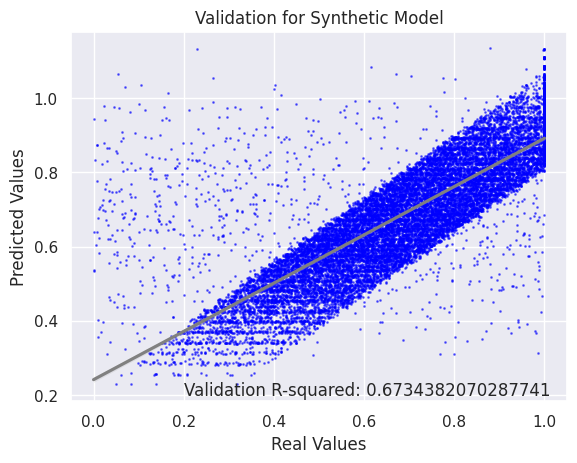

In [ ]:
sns.regplot(x=synthetic_observed_response, y=synthetic_validation_prediction, scatter_kws={'alpha':0.5, \
            'color':'blue', 's':1}, line_kws={'color': 'gray'})

plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Validation for Synthetic Model')

synthetic_r2_text = 'Validation R-squared: ' + str(synthetic_r2)
plt.text(0.2, 0.2, synthetic_r2_text)

plt.show()